In [23]:
import os, pdb
import numpy as np
import fitsio
from astropy.table import Table, vstack

import matplotlib.pyplot as plt

from desispec.fiberflat import apply_fiberflat
from desispec.fluxcalibration import apply_flux_calibration
from desispec.io import read_frame, fluxcalibration, fiberflat

from speclite import filters

%env DESI_LOGLEVEL=warning

env: DESI_LOGLEVEL=warning


In [33]:
import seaborn as sns
sns.set(context='talk', style='ticks', font_scale=1.3)
%matplotlib inline

In [3]:
filt = filters.load_filters('decam2014-g', 'decam2014-r', 'decam2014-z')

In [40]:
summary = Table(fitsio.read('/global/cfs/cdirs/desi/users/raichoor/fiberassign-sv1/sv1-exposures.fits'))
summary = summary[summary['SKY_MAG_AB_MED'] != -99.0]
#summary = summary[-5:]
summary

NIGHT,EXPID,TILEID,TILERA,TILEDEC,EXPTIME,MJDOBS,FIELD,TARGETS,EBV,NGFA,B_DEPTH,R_DEPTH,Z_DEPTH,AIRMASS_MIN,AIRMASS_MED,AIRMASS_MAX,MOON_SEP_DEG_MIN,MOON_SEP_DEG_MED,MOON_SEP_DEG_MAX,TRANSPARENCY_MIN,TRANSPARENCY_MED,TRANSPARENCY_MAX,FWHM_ASEC_MIN,FWHM_ASEC_MED,FWHM_ASEC_MAX,SKY_MAG_AB_MIN,SKY_MAG_AB_MED,SKY_MAG_AB_MAX,FIBER_FRACFLUX_MIN,FIBER_FRACFLUX_MED,FIBER_FRACFLUX_MAX
int64,int64,int64,float32,float32,float32,float32,str14,str8,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
20201214,67710,80605,36.448,-4.601,900.077,59198.176,XMM-LSS,QSO+LRG,0.0,564,22.5,20.1,21.9,1.2451736,1.2455541,1.2471671,120.25338,120.30306,120.30336,0.69070935,0.8702064,0.9234563,2.7823658,3.4129555,4.347182,20.247427,20.31155,20.39483,0.06531224,0.098779246,0.14149179
20201214,67711,80605,36.448,-4.601,900.064,59198.188,XMM-LSS,QSO+LRG,0.0,552,18.2,16.1,17.2,1.249222,1.253253,1.2584939,120.10548,120.10914,120.10943,0.647927,0.8484787,0.94794995,2.6857412,3.5938077,4.498588,20.204046,20.360844,20.419842,0.06309073,0.09078336,0.14835781
20201214,67712,80605,36.448,-4.601,900.056,59198.203,XMM-LSS,QSO+LRG,0.0,540,38.1,33.4,36.0,1.2625953,1.2705423,1.2793489,119.92088,119.92499,119.92519,0.64363074,0.9065384,0.9656678,2.2947626,3.0278943,4.416968,20.264883,20.37301,20.437677,0.06389628,0.12258679,0.19364204
20201214,67713,80605,36.448,-4.601,900.004,59198.215,XMM-LSS,QSO+LRG,0.0,534,57.2,51.9,58.0,1.2859056,1.298188,1.3107097,119.73667,119.74082,119.74104,0.8869024,0.9410246,0.9889291,2.262067,2.7493556,3.306608,20.251646,20.320005,20.614048,0.10623354,0.1449203,0.1952197
20201214,67733,80606,36.448,-4.501,900.026,59198.246,XMM-LSS,ELG,0.0,516,139.4,129.8,146.3,1.3752754,1.3982437,1.4216723,119.381065,119.38605,119.38616,0.88390404,0.9635546,1.0064566,1.7277094,2.071266,2.8421905,19.466116,19.533869,19.993343,0.1346536,0.2277677,0.29692516
20201214,67744,80607,106.74,56.1,900.026,59198.266,Lynx,QSO+LRG,0.0,504,321.1,295.9,348.0,1.2031448,1.2153925,1.229065,146.49149,146.49435,146.4944,0.934482,0.96582806,0.9780415,1.2995901,1.6906111,2.3101308,20.043856,20.568724,20.891033,0.1929806,0.3114685,0.43442997
20201214,67765,80607,106.74,56.1,900.089,59198.332,Lynx,QSO+LRG,0.052832678,618,436.2,389.3,419.9,1.1055142,1.1090584,1.1134448,146.80252,146.80626,146.80635,0.9321701,0.9681201,0.9982807,1.1449482,1.4727442,2.3819253,20.378086,20.503574,20.919384,0.18123527,0.3711595,0.5077853
20201214,67766,80607,106.74,56.1,900.069,59198.348,Lynx,QSO+LRG,0.05146826,612,409.4,353.7,367.0,1.0984625,1.1004287,1.1031283,146.86595,146.86981,146.86989,0.9303596,0.96563137,0.9849499,1.1986407,1.4794627,2.0802743,20.570374,20.665682,20.73877,0.22432755,0.36365494,0.47498247
20201214,67767,80607,106.74,56.1,900.063,59198.36,Lynx,QSO+LRG,0.04801854,594,337.2,299.9,312.9,1.0958822,1.0963798,1.0975016,146.92525,146.92928,146.92938,0.89822924,0.9627347,0.9846288,1.1263918,1.5960265,2.5263045,20.566174,20.656069,20.726759,0.16288762,0.3302436,0.4971697


In [5]:
expdir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'redux', 'daily', 'exposures')
calibdir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'redux', 'daily', 'calibnight')

In [6]:
def quick_coadd(wave, flux, ivar):
    """Make a quick coadd (of a single 3-camera spectrum) using 
    inverse variance weights.
    
    """
    uspecwave = np.unique(np.hstack(wave))
    uspecflux3d = np.zeros((len(uspecwave), 3))
    uspecivar3d = np.zeros_like(uspecflux3d)
    for icam in np.arange(3):
        I = np.where(np.isin(wave[icam], uspecwave))[0]
        J = np.where(np.isin(uspecwave, wave[icam]))[0]
        uspecflux3d[J, icam] = flux[icam]
        uspecivar3d[J, icam] = ivar[icam]

    uspecivar = np.sum(uspecivar3d, axis=1)
    uspecflux = np.zeros_like(uspecivar)
    good = np.where(uspecivar > 0)[0]
    uspecflux[good] = np.sum(uspecivar3d[good, :] * uspecflux3d[good, :], axis=1) / uspecivar[good]
    
    srt = np.argsort(uspecwave)
    return uspecwave[srt], uspecflux[srt], uspecivar[srt]

In [41]:
def gather_results(clobber=False):
    resultsfile = 'results.fits'
    if os.path.isfile(resultsfile) and not clobber:
        results = Table(fitsio.read(resultsfile))
        return results
    
    results = []
    for night in set(summary['NIGHT']):
        inight = np.where(night == summary['NIGHT'])[0]
        #print(summary[inight])    
        for expid in set(summary['EXPID'][inight]):
            print(night, expid)
            iexpid = np.where(expid == summary['EXPID'][inight])[0]
            #print(summary[inight][iexpid])
            datadir = os.path.join(expdir, str(night), '{:08d}'.format(expid))
            for spectro in ['0']:#, '1', '2', '3', '4', '5', '6', '7', '8', '9']:
                _skywave, _skyflux, _skyivar = [], [], []
                for camera in ['b', 'r', 'z']:
                    #print(spectro, camera)
                    framefile = os.path.join(datadir, 'frame-{}{}-{:08d}.fits'.format(camera, spectro, expid))
                    calibfile = os.path.join(datadir, 'fluxcalib-{}{}-{:08d}.fits'.format(camera, spectro, expid))
                    flatfile = os.path.join(calibdir, str(night), 'fiberflatnight-{}{}-{}.fits'.format(camera, spectro, night))
                    if os.path.isfile(framefile) and os.path.isfile(calibfile) and os.path.isfile(flatfile):
                        fr = read_frame(framefile)
                        flat = fiberflat.read_fiberflat(flatfile)
                        calib = fluxcalibration.read_flux_calibration(calibfile)
                    
                        apply_fiberflat(fr, flat)
                        apply_flux_calibration(fr, calib)
                        isky = np.where(fr.fibermap['OBJTYPE'] == 'SKY')[0]
                        if len(isky) > 0:
                            _skywave.append(fr.wave)
                            _skyflux.append(fr.flux[isky, :])
                            _skyivar.append(fr.ivar[isky, :])
            if len(_skyflux) == 0:
                continue
            nsky = _skyflux[0].shape[0]
            skywave, skyflux, skyivar = [], [], []
            for isky in np.arange(nsky):
                cwave, cflux, civar = quick_coadd(
                    _skywave, [_skyflux[0][isky, :], _skyflux[1][isky, :], _skyflux[2][isky, :]],
                             [_skyivar[0][isky, :], _skyivar[1][isky, :], _skyivar[2][isky, :]])
                skywave.append(cwave)
                skyflux.append(cflux)
                skyivar.append(civar)
            skywave = skywave[0] # np.vstack(skywave)
            skyflux = np.vstack(skyflux)
            skyivar = np.vstack(skyivar)
        
            padflux, padwave = filt.pad_spectrum(skyflux, skywave, method='edge')
            skymags = filt.get_ab_magnitudes(1e-17 * padflux, padwave)
        
            result = Table()
            result['night'] = [night]
            result['expid'] = [expid]
            result['gfa_sky_min'] = summary[inight][iexpid]['SKY_MAG_AB_MIN']
            result['gfa_sky_med'] = summary[inight][iexpid]['SKY_MAG_AB_MED']
            result['gfa_sky_max'] = summary[inight][iexpid]['SKY_MAG_AB_MAX']
            result['spec_sky_min'] = np.min(skymags['decam2014-r']).astype('f4')
            result['spec_sky_med'] = np.median(skymags['decam2014-r']).astype('f4')
            result['spec_sky_max'] = np.max(skymags['decam2014-r']).astype('f4')
            results.append(result)
    results = vstack(results)
    results.write(resultsfile, overwrite=True)
    
    return results

In [42]:
%time results = gather_results(clobber=True)

20201216 68265
20201216 68266
20201216 68272


/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/speclite/filters.py:1118: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(maggies)


20201216 68273
20201216 68284
20201216 68285
20201216 68288
20201216 68289
20201216 68290
20201216 68291
20201216 68292
20201216 68317
20201216 68327
20201216 68328
20201216 68330
20201216 68331
20201216 68332
20201216 68333
20201216 68334
20201216 68336
20201216 68337
20201216 68338
20201216 68339
20201216 68340
20201217 68488
20201217 68489
20201217 68490
20201217 68491
20201217 68492
20201217 68477
20201217 68478
20201218 68619
20201218 68630
20201218 68644
20201218 68645
20201218 68646
20201218 68657
20201218 68658
20201218 68659
20201218 68660
20201218 68661
20201218 68662
20201218 68663
20201218 68664
20201218 68666
20201218 68672
20201218 68673
20201218 68674
20201218 68675
20201218 68676
20201218 68677
20201218 68678
20201218 68681
20201218 68682
20201218 68683
20201218 68684
20201218 68685
20201218 68686
20201219 68879
20201219 68890
20201219 68892
20201219 68903
20201219 68790
20201219 68794
20201219 68795
20201219 68796
20201219 68797
20201219 68799
20201219 68800
20201219 6

In [29]:
results

night,expid,gfa_sky_min,gfa_sky_med,gfa_sky_max,spec_sky_min,spec_sky_med,spec_sky_max
int64,int64,float32,float32,float32,float32,float32,float32
20201221,69272,20.974617,21.13949,21.458323,20.171408,20.345585,20.870193
20201221,69273,20.82348,20.998652,21.38439,19.695196,19.908266,20.351957
20201221,69274,20.774685,20.935965,21.190914,19.290155,19.893057,20.346613
20201221,69275,20.744839,20.890163,21.274347,19.087189,19.433924,20.18591
20201221,69276,20.15629,20.582287,21.040854,17.417753,17.960354,18.600233


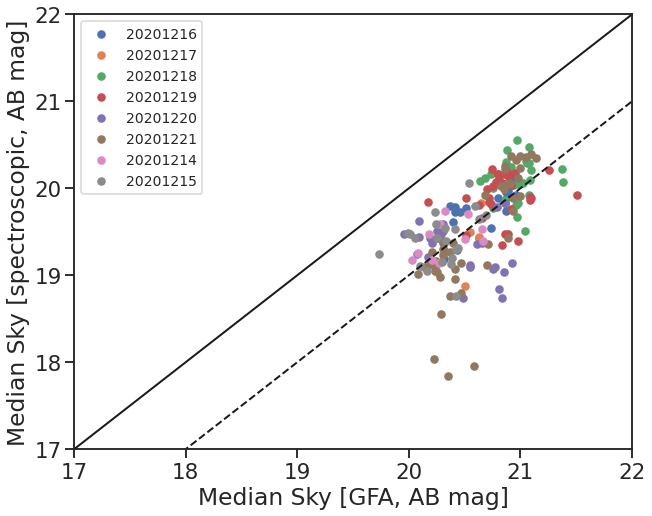

In [53]:
fig, ax = plt.subplots(figsize=(10, 8))
for night in set(results['night']):
    I = results['night'] == night
    ax.scatter(results['gfa_sky_med'][I], results['spec_sky_med'][I], s=50,
               label=night)
ax.legend(loc='upper left', fontsize=14)
ax.set_xlim(17, 22)
ax.set_ylim(17, 22)
ax.set_xlabel('Median Sky [GFA, AB mag]')
ax.set_ylabel('Median Sky [spectroscopic, AB mag]')
ax.plot([17, 22], [17, 22], color='k', lw=2, ls='-')
ax.plot([17, 22], [16, 21], color='k', lw=2, ls='--')
fig.savefig('gfasky-vs-specsky.png')

In [52]:
results['night'].max()

20201221